<font colors=black, size='5'> Analyzing Denver's Crime Data</font>

### Neil Oza
</font>



<font size='3'><b>Introduction</b></font>

Hello, my name is Neil Oza. I lived in Denver up until two months ago, and I am currently honing my data science skills. For practice and fun, I decided to see what information I could gleam from Denver's publicly available crime data. I will create some visualizations to help discover trends within the data. My goal is to organize this data in a way that would help law enforcement in Denver allocate their resources more efficiently. let's get started! 



<b><font size=3>Preparing the Data</font></b>

To start, I will import a few useful packages.
<br>
<br>

In [1]:
#Start by importing some useful packages

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import numpy as np
import folium
from folium import plugins


Next, I'll read in our data into a pandas dataframe

In [2]:
#Next, read in the data, publicly available at https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-crime
denver_data=pd.read_csv('../input/crime.csv', parse_dates=True)
denver_data.head(8)

INCIDENT_ID         OFFENSE_ID     ...      IS_CRIME  IS_TRAFFIC
0   2016376978   2016376978521300     ...             1           0
1  20186000994  20186000994239900     ...             1           0
2  20166003953  20166003953230500     ...             1           0
3    201872333    201872333239900     ...             1           0
4   2017411405   2017411405230300     ...             1           0
5    201872837    201872837549900     ...             1           0
6  20186001015  20186001015230400     ...             1           0
7    201870628    201870628570700     ...             1           0

[8 rows x 19 columns]

<br>
There are a total of 19 columns in this dataset. I reached out to the city of Denver and received clarification on several of the columns. I will briefly describe each column below. I will go slightly out of order to provide a more cohesive explanation
<br>
<br>
<b>OFFENSE_ID</b> is a unique identifier for each offense. It is generated by concatanating (combining) the INCIDENT_ID, OFFENSE_CODE,and OFFENSE_CODE_EXTENSION. It provides a unique identifier for each offense, as the INCIDENT_ID is duplicated if multiple offenses are committed at once, and OFFENSE_CODE and OFFENSE_CODE_EXTENSION will repeat whenever a particular type of offense is committed

<b>INCIDENT_ID</b> is a unique identifier for an occurence of offenses. most OFFENSE_ID's have unique INCIDENT_ID's, but when a person commits multiple offenses at once, e.g. liquor possession and heroine possession, multiple OFFENSE_ID's will be generated from the INCIDENT_ID

<b>OFFENSE_CODE</b> is a unique identifier for a particular type of offense. things such as criminal mischief, trespassing, larceny, etc. all have different OFFENSE__CODE values to identify them

<b>OFFENSE_CODE_EXTENSION</b> are used to describe a subset of another type crime. for example criminal_mischief- motor vehicle and criminal_mischief-other have the same OFFENSE_CODE but different extensions to differentiate them

<b>OFFENSE_TYPE_ID</b> provides the actual name for the offense in lamens terms. each combination of OFFENSE_CODE and OFFENSE_EXTENSION reference a unique crime. contents of this column include things such as theft-shoplift, criminal-trespassing, and threats-to-injure

<b>OFFENSE_CATEGORY_ID</b> provides a more general categorization for crimes. for example, theft-shoplift and theft-from-bldg are both forms of larceny

<b>FIRST_OCCURENCE_DATE</b> is the first possible date/time of the offense. if the time of the offense is known, the LAST_OCCURENCE_DATE will have value NaN. if the time is not known, FIRST_OCCURENCE_DATE will note the first possible time for the offense, and LAST_OCCURENCE_DATE will be last possible time of the offense. This commonly occurs with burglaries, where the exact time of the offense may not be known, but a range of time is known

<b>LAST_OCCURENCE_DATE</b> will be NaN if the exact time of the offense is known and will be an actual time if only a range of possible times is known. in the latter case, it will be the last possible time the offense could have occured.

<b>REPORTED_DATE</b> is the time at which the offense was reported to the police

<b>INCIDENT_ADDRESS</b> provides the location of the offense. not all entries have a value for this column for privacy reasons

<b>GEO_LON</b> and <b>GEO_LAT</b> are the latitudes and longitudes of the location of the offense

<b>GEO_X</b> and <b>GEO_Y</b> are the state plane (city of Denver standard projection) for the offense location. functionally simlar to GEO_LON and GEO_LAT

<b>DISTRICT_ID</b> is the district in charge of handling the offense

<b>PRECINCT_ID</b> is the precinct in charge of handling the offense

<b>NEIGHBORHOOD_ID</b> is the neighborhood the offense occurred in

<b>IS_CRIME</b> states whether the offense was a crime

<b>IS_TRAFFIC</b> states whether the offense was a traffic incident




<br>
<br>
Now that we have an overview of the data, II'll make sure it contains no errors. To start, I'll check for null values

In [3]:
#Check to see how many non-null values present
denver_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467928 entries, 0 to 467927
Data columns (total 19 columns):
INCIDENT_ID               467928 non-null int64
OFFENSE_ID                467928 non-null int64
OFFENSE_CODE              467928 non-null int64
OFFENSE_CODE_EXTENSION    467928 non-null int64
OFFENSE_TYPE_ID           467928 non-null object
OFFENSE_CATEGORY_ID       467928 non-null object
FIRST_OCCURRENCE_DATE     467928 non-null object
LAST_OCCURRENCE_DATE      147953 non-null object
REPORTED_DATE             467928 non-null object
INCIDENT_ADDRESS          421949 non-null object
GEO_X                     464116 non-null float64
GEO_Y                     464116 non-null float64
GEO_LON                   464116 non-null float64
GEO_LAT                   464116 non-null float64
DISTRICT_ID               467928 non-null int64
PRECINCT_ID               467928 non-null int64
NEIGHBORHOOD_ID           467928 non-null object
IS_CRIME                  467928 non-null int64
IS_TRAFFIC

Based on the above output, many of the columns have identical numbers of non-null data. this suggests that the places with null values were left so intentionally. Upon further investigation, it seems that the geographical locations are smetimes left null for privacy reasons and the Last Reported Date column is sometimes left null because the crime occurred at a known time. There don't to be any truly missing values in the dataset, which is good news


Now I'll make sure all Offnse Codes are unique. Specifically, I want to make sure every OFFENSE_CODE and OFFENSE_CODE_EXTENSION combination has a unique OFFENSE_TYPE_ID; If this is not the case, that would mean tat sometimes crime 910 sometimes refered to homicide and other times referred to petty theft. It's important that each code references a unique crime for the sake of ,y analysis, so I will validate that now.

In [4]:
temp=display(denver_data.groupby([denver_data.OFFENSE_CODE,denver_data.OFFENSE_CODE_EXTENSION,denver_data.OFFENSE_TYPE_ID]).size())
pd.set_option('display.max_rows',500)
print(temp)

OFFENSE_CODE  OFFENSE_CODE_EXTENSION  OFFENSE_TYPE_ID              
902           0                       homicide-family                     21
910           0                       homicide-negligent                   2
912           0                       homicide-other                     224
1006          0                       kidnap-adult-victim                210
              1                       kidnap-dv                          165
1099          0                       false-imprisonment                 371
1102          0                       sex-aslt-rape                     2212
              1                       sex-aslt-rape-pot                  142
1109          0                       sex-aslt-non-rape                  511
              1                       sex-aslt-non-rape-pot              119
1199          0                       sex-aslt-w-object                   26
              1                       sex-aslt-w-object-pot                5
1202    

None


Some offense codes have multiple extensions as indicated by the blank spaces in the OFFENSE_CODE column, but every offense code and extension pair has exactly one offense type id. There are no multiplicities in categorization, so the offense codes are free of errors.
<br>
Next I'll make sure all of the dates are consistent. As a rule, First Occurence Date should come first, Last Occurence Date should come second or not exist, and Reported Date should come last. If this is not the case for a particular entry, that row will be removed from the dataset and printed below so it can be corrected.

In [5]:
#convert relevant column data into datetime objects
denver_data['REPORTED_DATE']=pd.to_datetime(denver_data.REPORTED_DATE)
denver_data['FIRST_OCCURRENCE_DATE']=pd.to_datetime(denver_data.FIRST_OCCURRENCE_DATE)
denver_data['LAST_OCCURRENCE_DATE']=pd.to_datetime(denver_data.LAST_OCCURRENCE_DATE)


In [6]:
# Calculate the time difference between first and last occurence date. negative time means the Last Occurence is dated
# before first occurence. those entries have been listed with OFFENSE_ID for easy access
temp=denver_data[['OFFENSE_ID','FIRST_OCCURRENCE_DATE','LAST_OCCURRENCE_DATE','REPORTED_DATE']]
temp.loc[:,'OCCURENCE_WINDOW']=temp.LAST_OCCURRENCE_DATE-temp.FIRST_OCCURRENCE_DATE
temp.loc[:,'OCCURENCE_WINDOW']=temp.OCCURENCE_WINDOW.fillna(0)
print(temp[temp['OCCURENCE_WINDOW']<'0'])
duds=temp[temp['OCCURENCE_WINDOW']<'0'].OFFENSE_ID
#remove rows with errors
denver_data=denver_data[~denver_data['OFFENSE_ID'].isin(duds)]
#print the OFFENSE_ID's of rows wih errors


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


               OFFENSE_ID        ...         OCCURENCE_WINDOW
50870    2014388104570700        ...        -1 days +23:31:00
51468    2014373704299901        ...        -1 days +23:00:00
57663    2014353737299901        ...        -1 days +23:01:00
60991    2014399282240400        ...        -1 days +22:23:00
69814    2014596887131302        ...        -1 days +23:45:00
74842   20149515342240400        ...        -1 days +12:33:00
107593   2015539465240400        ...        -1 days +19:44:00
118527    201594326239900        ...        -1 days +22:25:00
129250   2015752334570700        ...        -1 days +04:00:00
131395   2016151736355000        ...        -1 days +23:35:00
146179   2016415601220400        ...        -1 days +13:48:00
160428   2016751799240400        ...        -1 days +23:45:00
172898   2017122300240400        ...        -1 days +17:10:00
180219   2017115679299900        ...        -1 days +20:50:00
181468    201719458220401        ...        -1 days +13:54:00
184996  

39 entries have last occurence dates that are earlier than first occurence dates. Based on the occurence window, the first and last occurence days should be flipped. At any rate, these entries will be dropped from the dataset

In [7]:
#check that reported dates are after first/last occurence dates
temp=denver_data[['OFFENSE_ID','FIRST_OCCURRENCE_DATE','LAST_OCCURRENCE_DATE','REPORTED_DATE']]
temp.loc[:,'OCC_REPORT_GAP']=temp.REPORTED_DATE-temp.LAST_OCCURRENCE_DATE
temp.loc[:,'OCC_REPORT_GAP']=temp.OCC_REPORT_GAP.fillna(temp.REPORTED_DATE-temp.FIRST_OCCURRENCE_DATE)
#list all instances where reported date is before either of the occurence dates
print(temp[temp['OCC_REPORT_GAP']<'0'])
duds2=temp[temp['OCC_REPORT_GAP']<'0'].OFFENSE_ID
denver_data=denver_data[~denver_data['OFFENSE_ID'].isin(duds2)]


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


               OFFENSE_ID        ...           OCC_REPORT_GAP
8833     2018425958131600        ...        -1 days +23:09:00
16620    2018409124549900        ...        -1 days +22:09:00
16621    2018409124544100        ...        -1 days +22:09:00
47904     201987477240400        ...        -1 days +23:50:00
58919    2014436425357200        ...        -1 days +23:36:00
58920    2014436425351200        ...        -1 days +23:36:00
67434    2014560314580100        ...        -1 days +21:37:00
67435    2014560314544100        ...        -1 days +21:37:00
75609    2014523161544100        ...        -1 days +22:23:00
75610    2014523161549900        ...        -1 days +22:23:00
86927    2014615636240400        ...        -1 days +23:55:00
86928    2014615636540100        ...        -1 days +23:55:00
99490    2015279235501500        ...        -1 days +22:57:00
122015    201597530239900        ...        -1 days +15:33:00
131080    201628962545500        ...        -1 days +23:42:00
144939  

The above entries have Reported Dates earlier than Last Occurence Dates. These entries should be reveiwed for mistakes, and for now won't be used in this analysis
<br>
<br>
Now Lets make sure all of the Offense ID's are properly constructed from the Incident ID, Offense Code, and Offense Extension


In [8]:
#Determine if there are mistakes in the OFFENSE_ID column
#prepare the columns
temp=denver_data[['OFFENSE_ID','INCIDENT_ID','OFFENSE_CODE','OFFENSE_CODE_EXTENSION']]
temp.OFFENSE_ID=temp.OFFENSE_ID.astype(str)
temp.INCIDENT_ID=temp.INCIDENT_ID.astype(str)
#the below two columns have to be homogonized to 4 digits and 2 digits respectively
temp.OFFENSE_CODE=temp.OFFENSE_CODE.map('{:04d}'.format).astype(str)
temp.OFFENSE_CODE_EXTENSION=temp.OFFENSE_CODE_EXTENSION.map('{:02d}'.format).astype(str)
#Combine the composite columns and check to make sure it's the same as the OFFENSE_ID
temp['COMBINED_ID']=temp.INCIDENT_ID+temp.OFFENSE_CODE+temp.OFFENSE_CODE_EXTENSION
temp['ID_MATCH']=temp.COMBINED_ID==temp.OFFENSE_ID
#print all rows which have mistakes. will return no rows if there are no errors
print(temp[temp['ID_MATCH']==False])



/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

Empty DataFrame
Columns: [OFFENSE_ID, INCIDENT_ID, OFFENSE_CODE, OFFENSE_CODE_EXTENSION, COMBINED_ID, ID_MATCH]
Index: []


Since there was no output, there were no errors. All of the Offense ID's are correctly constructed from their composite parts.

Finally, I am only going to analyze crimes in this EDA, so I'll filter out all of the traffic incidents. I will also create a few extra columns at the end of our dataset that will simplify coding later

In [9]:
#filter out traffic accidents from the crime dataset
denver_crime=denver_data[denver_data['IS_CRIME']==1]
denver_crime=denver_crime[denver_crime['REPORTED_DATE']<'2019']
#add columns indicating the hour, day, month, and year eeach crime occurred
denver_crime['HOUR_REPORTED']=pd.DatetimeIndex(denver_crime['REPORTED_DATE']).hour
denver_crime['WEEKDAY_REPORTED']=pd.DatetimeIndex(denver_crime['REPORTED_DATE']).weekday
denver_crime['MONTH_REPORTED']=pd.DatetimeIndex(denver_crime['REPORTED_DATE']).month
denver_crime['YEAR_REPORTED']=pd.DatetimeIndex(denver_crime['REPORTED_DATE']).year

denver_crime


INCIDENT_ID      ...        YEAR_REPORTED
0        2016376978      ...                 2016
1       20186000994      ...                 2018
2       20166003953      ...                 2016
3         201872333      ...                 2018
4        2017411405      ...                 2017
5         201872837      ...                 2018
6       20186001015      ...                 2018
7         201870628      ...                 2018
9       20186001048      ...                 2018
10        201872390      ...                 2018
11      20186001033      ...                 2018
12       2016340553      ...                 2016
13       2017383968      ...                 2017
14       2016236602      ...                 2016
15      20176004695      ...                 2017
16       2017395809      ...                 2017
17        201869174      ...                 2018
18        201869047      ...                 2018
20        201871171      ...                 2018
23        201871362      ...                 2018
24        201870800      ...                 2018
25        201871768      ...                 2018
26      20188004580      ...                 2018
27        201871234      ...                 2018
28       2017294559      ...                 2017
29       2016398281      ...                 2016
30        201872460      ...                 2018
31       2016309815      ...                 2016
32      20186001018      ...                 2018
33      20188004582      ...                 2018
34        201872177      ...                 2018
35       2017510328      ...                 2017
36       2016256044      ...                 2016
37      20186001049      ...                 2018
38        201871376      ...                 2018
39        201872530      ...                 2018
40        201870965      ...                 2018
41        201870850      ...                 2018
42        201872599      ...                 2018
44       2016229783      ...                 2016
45       2016330967      ...                 2016
46        201872651      ...                 2018
47       2017791814      ...                 2017
48        201798629      ...                 2017
50      20166003736      ...                 2016
51      20188002481      ...                 2018
52        201873047      ...                 2018
53      20186000998      ...                 2018
54      20186001012      ...                 2018
57       2017672637      ...                 2017
58       2016256044      ...                 2016
59       2017340564      ...                 2017
60       2017793822      ...                 2017
61        201871651      ...                 2018
62      20176003548      ...                 2017
63        201872844      ...                 2018
64       2017217446      ...                 2017
65        201871312      ...                 2018
66       2016404251      ...                 2016
67        201870770      ...                 2018
68      20186000997      ...                 2018
71        201871024      ...                 2018
72        201869587      ...                 2018
73        201872401      ...                 2018
74       2017564393      ...                 2017
75        201869507      ...                 2018
76        201872610      ...                 2018
77        201872039      ...                 2018
79        201873000      ...                 2018
80      20166004826      ...                 2016
81        201870762      ...                 2018
82       2017653090      ...                 2017
83        201868398      ...                 2018
84        201871942      ...                 2018
85      20186001002      ...                 2018
87        201871888      ...                 2018
88       2016272033      ...                 2016
89        201871263      ...                 2018
90        201871843      ...                 2018
91      

<br>
<br>
<br>
<font size=3><b>Preliminary Analysis</b></font>

Now that the data's been primed, I will begin my analysis. To start, I'll get a general overview of Denver's crime trend over the past few years. For the record, I'll be using the REPORTED_DATE to timestamp all crimes since that is when the crime comes to a police department's attention.
<br>

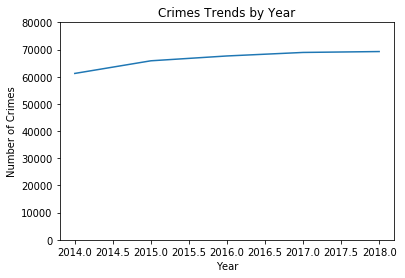

In [10]:
#How has the amount of crime in Denver changed these past five years?
denver_crime['YEAR_REPORTED'].groupby(denver_crime.YEAR_REPORTED).agg('count').plot('line')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.title('Crimes Trends by Year')
plt.ylim(bottom=0,top=80000)
plt.show()

There is a slight upward trend in crime over the past five years. However, the trend seems to be leveling off, and it wouldn't be surprising if crime actually decreased in 2019

Next let's take a look at what types of crimes are being committed in Denver.

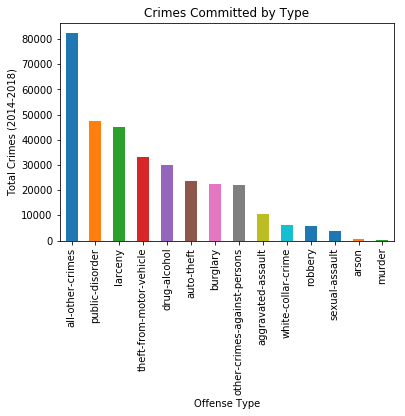

In [11]:
denver_crime['OFFENSE_CATEGORY_ID'].value_counts().plot(kind='bar')
plt.title('Crimes Committed by Type')
plt.xlabel('Offense Type')
plt.ylabel('Total Crimes (2014-2018)')
plt.show()

all-other-crimes seems to be the largest category, which we will take a closer look at in a moment. A lot of the large categories of crime seem to be forms of theft (larceny, theft-from-motor-vehicle, auto-theft, burglary). this suggests that theivery is a serious problem in Denver. beyond those crimes, drug-alcohol and public-disorder crimes seem to comprise most of the rest of Denver crimes. Violent crimes, such as assualt, robbery, and murder are low, which is a good sign.

Next, let's take a closer look at the all_other_crimes category.

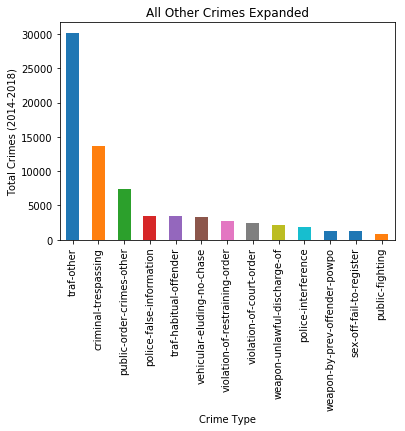

In [12]:
#only listing the top thirteen subdivisions of 'all-other-crimes', for sake of space
temp=denver_crime[denver_crime['OFFENSE_CATEGORY_ID']=='all-other-crimes'].OFFENSE_TYPE_ID.value_counts().head(13).plot(kind='bar')
plt.title('All Other Crimes Expanded')
plt.xlabel('Crime Type')
plt.ylabel('Total Crimes (2014-2018)')
plt.show()

Most of the crimes in this category seem to be traffic related, but from the label it's difficult to gleam what type of traffic incident is occuring. The other biggest chunk of this misc. category is criminal-trespassing, which if it were it's own category would eclipse aggravated-assualt in terms of number of occurences.

For completeness, let's also take a look at other-crimes-against-persons, which is another composite category, to see what it contains.

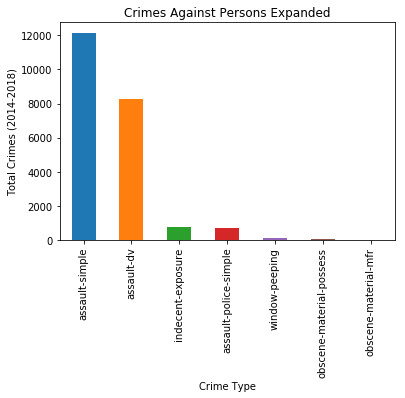

In [13]:
denver_misc_crimes=denver_crime[denver_crime['OFFENSE_CATEGORY_ID']=='other-crimes-against-persons'].OFFENSE_TYPE_ID.value_counts().plot(kind='bar')
plt.title('Crimes Against Persons Expanded')
plt.xlabel('Crime Type')
plt.ylabel('Total Crimes (2014-2018)')
plt.show()

other-crimes-against-persons seem to primarily composed of assualts, with a bit of spying and flashing mxed in. Given it's composition, this category will be most influenced by the number of assualts within it, so I'd personally consider the category elated to aggravated-assualt.

<font size=3><b> Crimes Viewed through Various Timeframes</b></font>

Now that I have an overview of the data, I'll begin looking at the data through various time frames. Specifically, I want to see if crimes are seasonal and if certain types of crimes have become more common over time. Let's start by breaking down each type of crime over the last five years.

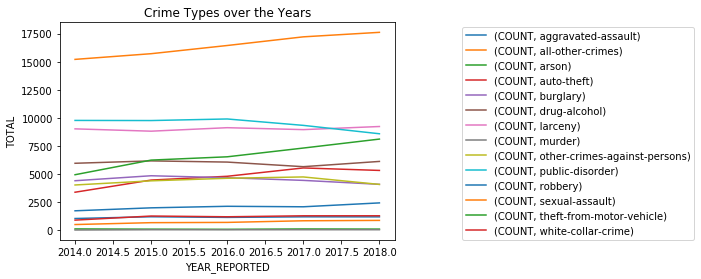

In [14]:
temp=denver_crime[['YEAR_REPORTED','OFFENSE_CATEGORY_ID']].groupby([denver_crime.YEAR_REPORTED, denver_crime.OFFENSE_CATEGORY_ID]).agg('count')
temp=temp.drop(labels='YEAR_REPORTED',axis=1)
temp.columns=['COUNT']
temp=temp.unstack(level=1)
temp.plot(kind='line')
plt.legend(loc=(1.2,0))
plt.ylabel('TOTAL')
plt.title('Crime Types over the Years')
plt.show()

According to the above graph, all-other-crimes, theft-from-motor-vehicle, and auto-theft all have become more common over the past three years. public-disorder has decreased while other crimes seem to be staying level. Given the increase in auto-theft and theft-from-motor-vehicles, it seems that some sort of PSA reminding people to lock up their vehicles may be warranted.

Next lt's take a look at these crimes by month. Specifically, we are looking to see if certain months have more crimes than others, and if certain types of crimes become more common in certain seasons.

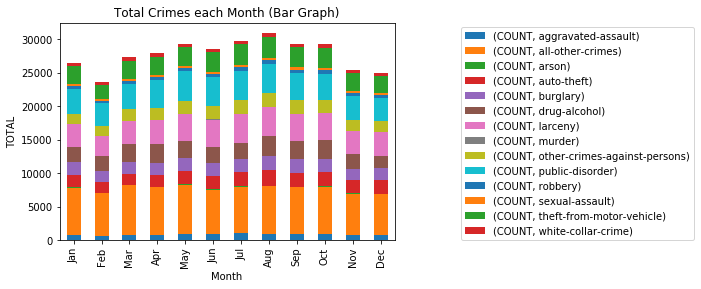

In [15]:
# br graph of crimes by month, to see if crime is seasonal
temp=denver_crime[['MONTH_REPORTED','OFFENSE_CATEGORY_ID']].groupby([denver_crime.MONTH_REPORTED, denver_crime.OFFENSE_CATEGORY_ID]).agg('count')
temp=temp.drop(labels='MONTH_REPORTED',axis=1)
temp.columns=['COUNT']
temp=temp.unstack(level=1)
ax=temp.plot(kind='bar',stacked=True)
plt.legend(loc=(1.2,0))
plt.title('Total Crimes each Month (Bar Graph)')
plt.xlabel('Month')
plt.ylabel('TOTAL')
ax.set_xticklabels(('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'))
plt.show()

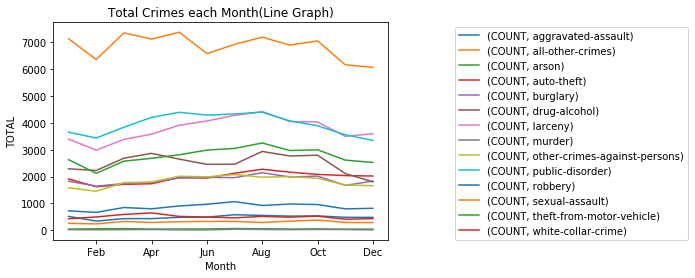

In [16]:
#line graph of crimes by month to see if certain crimes increase noticeably in certain months
temp=denver_crime[['MONTH_REPORTED','OFFENSE_CATEGORY_ID']].groupby([denver_crime.MONTH_REPORTED, denver_crime.OFFENSE_CATEGORY_ID]).agg('count')
temp=temp.drop(labels='MONTH_REPORTED',axis=1)
temp.columns=['COUNT']
temp=temp.unstack(level=1)
ax=temp.plot(kind='line')
plt.legend(loc=(1.2,0))
plt.title('Total Crimes each Month(Line Graph)')
plt.xlabel('Month')
plt.ylabel('TOTAL')
ax.set_xticklabels(('','Feb','Apr','Jun','Aug','Oct','Dec'))

plt.show()

based on the above graphics, it seems crimes are more common in the summer than the winter in denver. We don't have to eyeball it though; we can conduct a hypothesis test to see if different numbers of crimes occur in the summer vs the winter. For the purposes of this test, I will consider December, January, and February to be the winter months and June, July, and August to be the winter months and June July and August to be the summer months. I will conduct a two sample t-test to see if the average day in each season have the same number of crimes.

In [17]:
summer=denver_crime[(denver_crime['MONTH_REPORTED']==8)|(denver_crime['MONTH_REPORTED']==6)|(denver_crime['MONTH_REPORTED']==7)]
winter=denver_crime[(denver_crime['MONTH_REPORTED']==12)|(denver_crime['MONTH_REPORTED']==1)|(denver_crime['MONTH_REPORTED']==2)]
summer=summer.REPORTED_DATE.dt.date.groupby(summer.REPORTED_DATE.dt.date).agg('count')
winter=winter.REPORTED_DATE.dt.date.groupby(winter.REPORTED_DATE.dt.date).agg('count')
stats.ttest_ind(summer,winter,equal_var=False)


Ttest_indResult(statistic=14.501338218405742, pvalue=1.0639198477586844e-42)

Since the p-value is well less than 1% we can conclude that the summer and winter have very different mean crimes per day. Next we'll check crimes by day of the week.

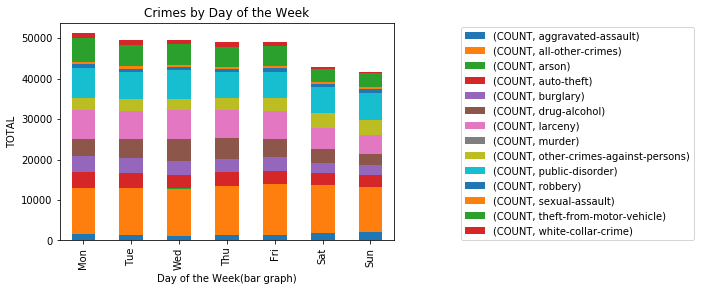

In [18]:
#bar graph of total crimes by day of the week
temp=denver_crime[['WEEKDAY_REPORTED','OFFENSE_CATEGORY_ID']].groupby([denver_crime.WEEKDAY_REPORTED, denver_crime.OFFENSE_CATEGORY_ID]).agg('count')
temp=temp.drop(labels='WEEKDAY_REPORTED',axis=1)
temp.columns=['COUNT']
temp=temp.unstack(level=1)
ax=temp.plot(kind='bar',stacked=True)
plt.legend(loc=(1.2,0))
plt.xlabel('Day of the Week(bar graph)')
plt.ylabel('TOTAL')
plt.title('Crimes by Day of the Week')
ax.set_xticklabels(('Mon','Tue','Wed','Thu','Fri','Sat','Sun'))
plt.show()





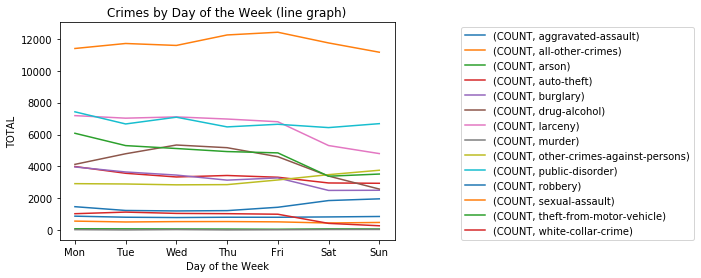

In [19]:
#line graph of each type of crime by day of the week
temp=denver_crime[['WEEKDAY_REPORTED','OFFENSE_CATEGORY_ID']].groupby([denver_crime.WEEKDAY_REPORTED, denver_crime.OFFENSE_CATEGORY_ID]).agg('count')
temp=temp.drop(labels='WEEKDAY_REPORTED',axis=1)
temp.columns=['COUNT']
temp=temp.unstack(level=1)
ax=temp.plot(kind='line')
plt.legend(loc=(1.2,0))
plt.title('Crimes by Day of the Week (line graph)')
plt.xlabel('Day of the Week')
plt.ylabel('TOTAL')
ax.set_xticklabels(('','Mon','Tue','Wed','Thu','Fri','Sat','Sun'))
plt.show()

It appears that crime generally occurs on the weekdays as opposed to weekends (even criminals need a day off). in particular, theft-from-motor-vehicle and larceny crime rates drop precipitously on weekends. drug-alcohol crimes seem to occur from Tuesday through Friday, and interestingly both aggravated-assualt and other-crimes-against-persons occur more frequently on weekends. I'm not quite sure why that is, but further research might reveal the answer.

I'll run another quick hypothesis test to determine if a different number of crimes occur on weekends as opposed to weekdays.

In [20]:
weekday=denver_crime[(denver_crime['WEEKDAY_REPORTED']<5)]
weekend=denver_crime[(denver_crime['WEEKDAY_REPORTED']>=5)]
weekday=weekday.REPORTED_DATE.dt.date.groupby(weekday.REPORTED_DATE.dt.date).agg('count')
weekend=weekend.REPORTED_DATE.dt.date.groupby(weekend.REPORTED_DATE.dt.date).agg('count')
stats.ttest_ind(weekday,weekend,equal_var=False)

Ttest_indResult(statistic=21.83844857162146, pvalue=2.567900994035011e-88)

the above t-test shows that there is well less than a 1% chance the same number of crimes occur on weekends vs weekdays

Now I'll analyze crime by the hour of the day. I'm curious to see if certain crimes are more common in morning hours versus evening hours. note that to keep things clear, I'll be using military time in the below graphs. 6 represents 6 AM, while 18 represents 6 PM.

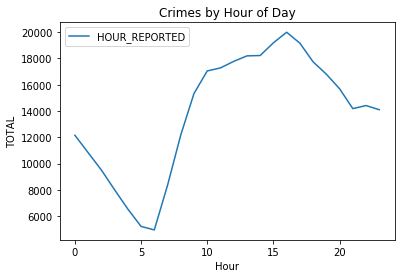

In [21]:
#create lineplot to see crime trends of total crimes throughout the day
temp=denver_crime[['HOUR_REPORTED']].groupby([denver_crime.HOUR_REPORTED]).agg('count')
temp.plot(kind='line')
plt.xlabel('Hour')
plt.ylabel('TOTAL')
plt.title('Crimes by Hour of Day')
plt.show()

No handles with labels found to put in legend.


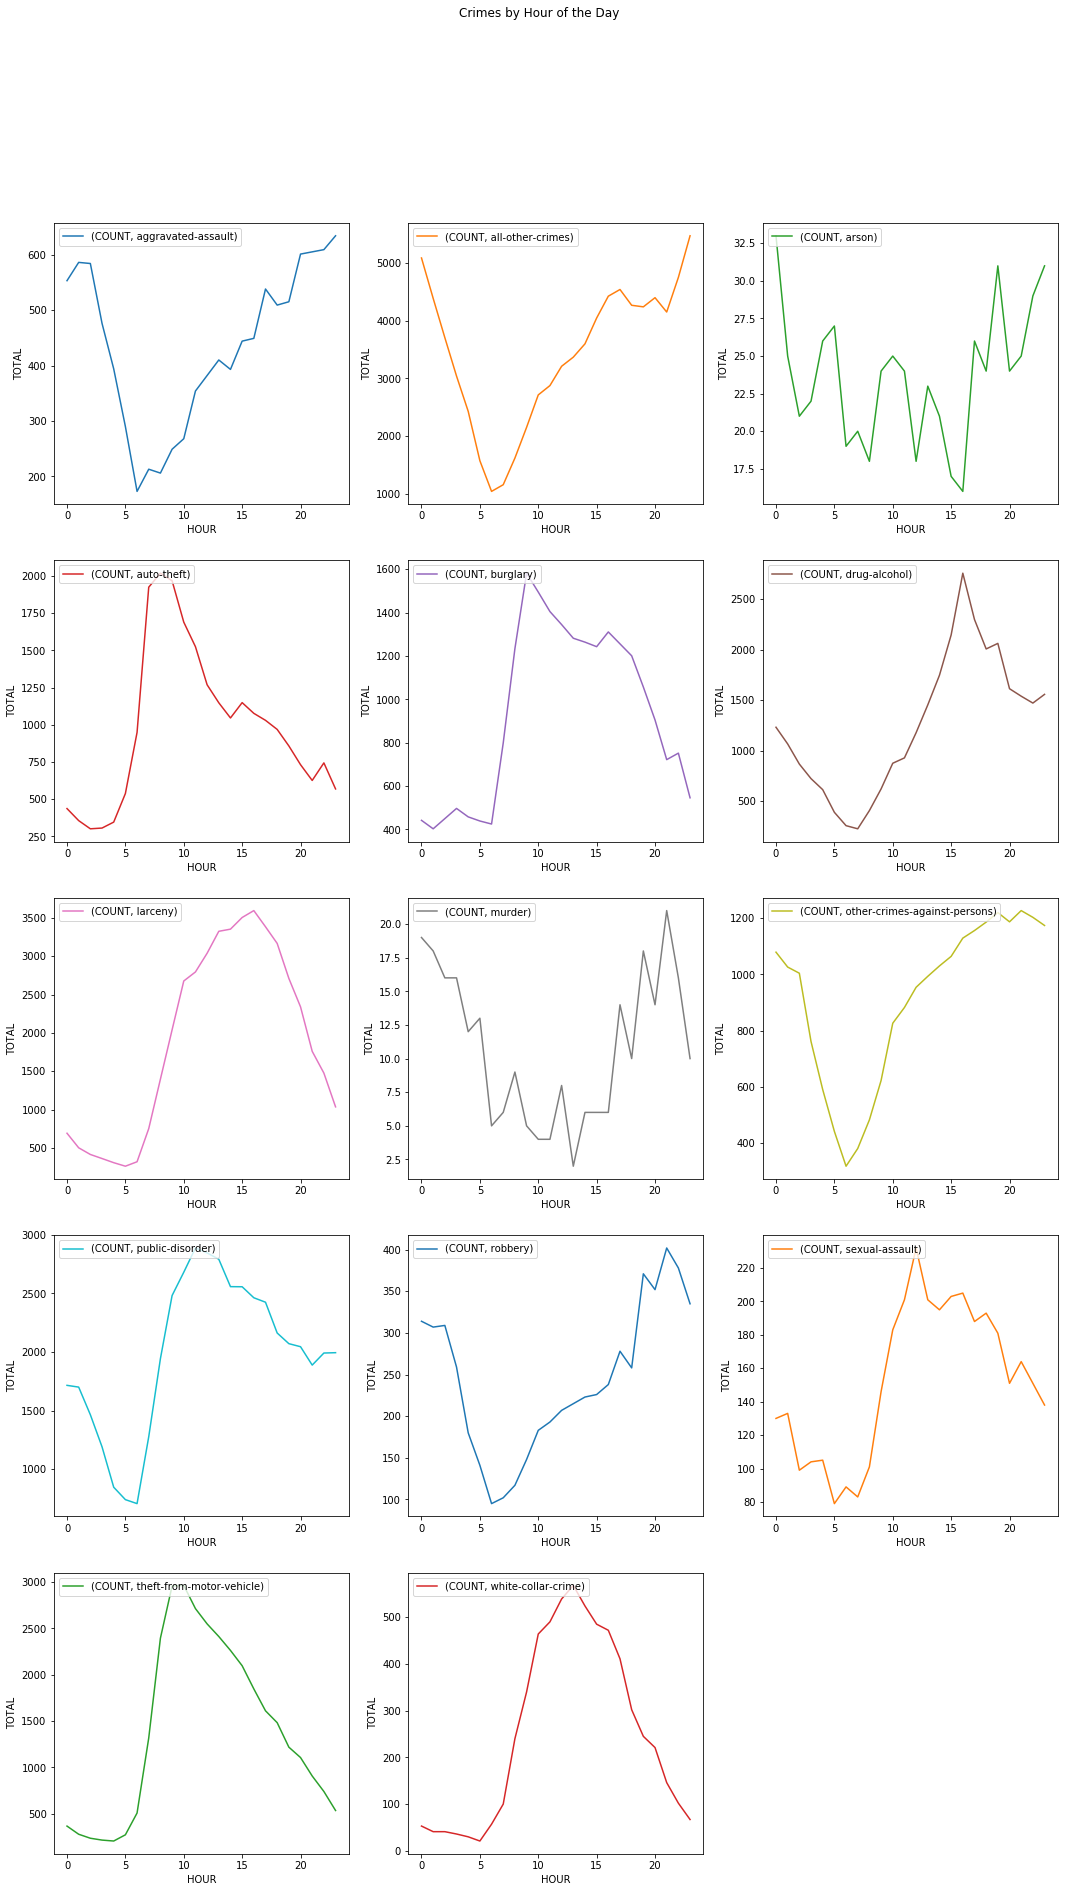

In [22]:
temp=denver_crime[['HOUR_REPORTED','OFFENSE_CATEGORY_ID']].groupby([denver_crime.HOUR_REPORTED, denver_crime.OFFENSE_CATEGORY_ID]).agg('count')
temp=temp.drop(labels='HOUR_REPORTED',axis=1)
temp.columns=['COUNT']
temp.index=temp.index.rename('HOUR',level=0)

temp=temp.unstack(level=1)
fig=temp.plot(kind='line', figsize=(18,30),subplots=True,layout=(-1,3),sharex=False,sharey=False)
for row in fig:
    for item in row:
        item.set_ylabel('TOTAL')
        item.legend(loc='upper left')
plt.suptitle('Crimes by Hour of the Day')
plt.show()



There are some interesting trends here. First and formost, it seems like most crimes occur betwwen 8 AM and 8 PM with a noticeable dip in crime from 1 AM to 5 AM. Different types of crimes seem to be prevalent at different times of the day. aggravated-assualt, robbery, and other-crimes-against-persons seem to be most common late at night, betwen 10 PM and 2 AM. Auto-theft, theft-from-notor-vehicle, and larceny seem to be most common from 9 AM to 5 PM, which is also when people are at work. Since thefts have increased significantly over the past five years, reminding people to lock their cars and possessions before going to work may help address some of this crime. the crimes of murder and arson are too infrequent to come up with a meaningful trend statement.

<b><font size=3> Crimes by District</b></font>

The above section focused on crime trends temporally. In this section, I'll focus on crimes by district, while also breaking up those crimes by yar. This should tell us which districts are seeing crime rates increase, and what types of crimes are increasing. Also, by breaking crimes up by district we'll be able to see if certain districts have an abnormally large amounts of particular crimes. To start, I'll take a look at total crime trends for each district over the past five years.

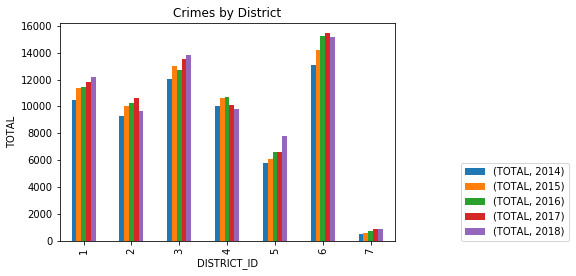

In [23]:
#analyze crime by district in each of the past five years
temp=denver_crime[['REPORTED_DATE','DISTRICT_ID']].groupby([denver_crime.REPORTED_DATE.dt.year, denver_crime.DISTRICT_ID]).agg('count')
temp=temp.drop(labels='REPORTED_DATE',axis=1)
temp.columns=['TOTAL']
temp=temp.unstack(level=0)
temp.plot(kind='bar',stacked=False)
plt.ylabel('TOTAL')
plt.title('Crimes by District')
plt.legend(loc=(1.2,0))
plt.show()

Districts 6, 3, and 1 are the largest, while district 7 is the smallest by a large margin. Crime seems to be trending upward over time in every district wih the exception of district 4 and possibly district 2, though in the latter case the data isn't conclusive.

Next let's take a look at the prevalence of different types of crimes in each district. We would expect those distributions to be similar to the above distribution. If that turns out not to be the case it would suggest that the crime is dispraportionately represented in that district.

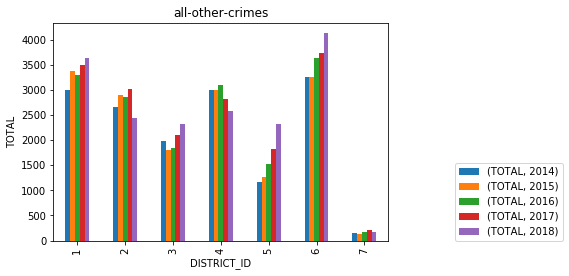

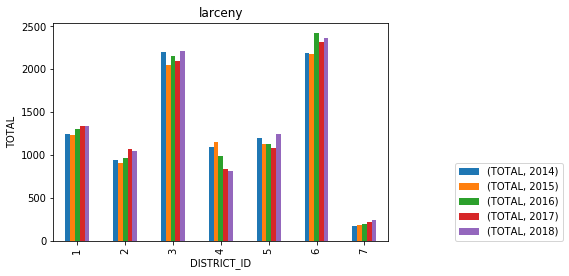

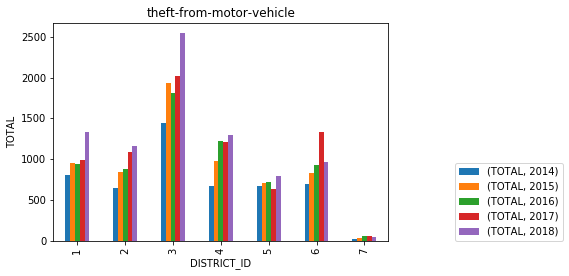

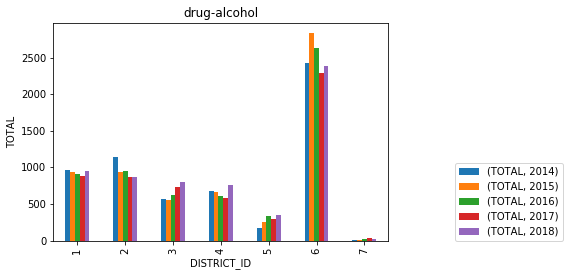

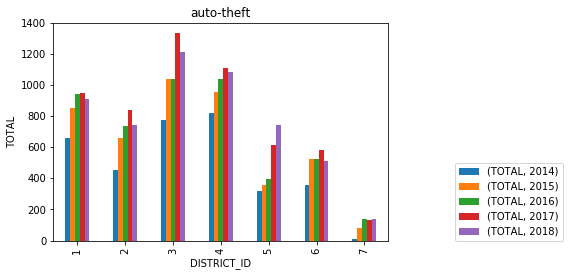

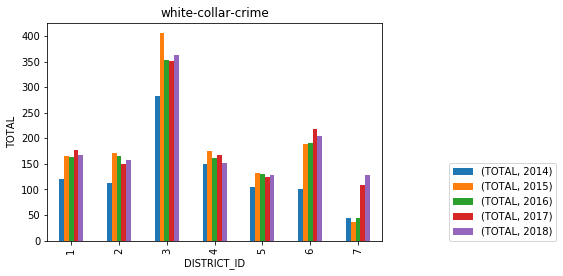

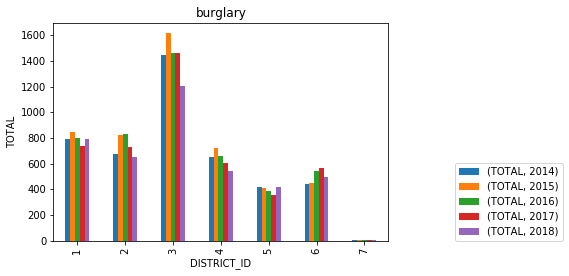

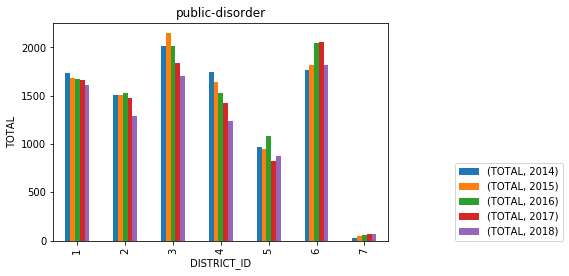

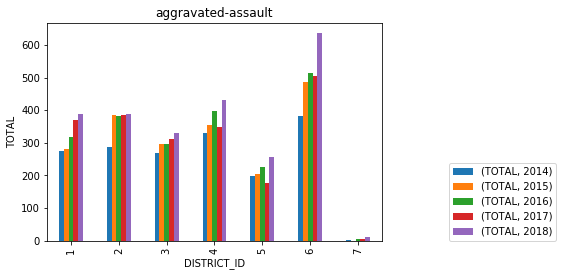

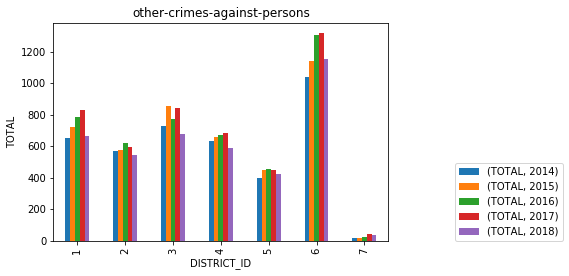

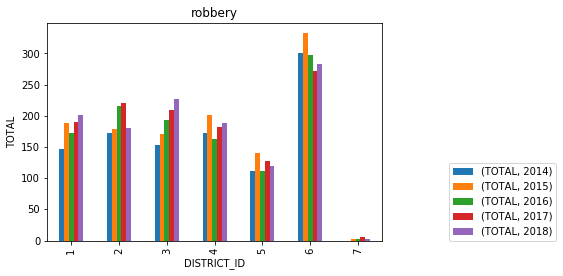

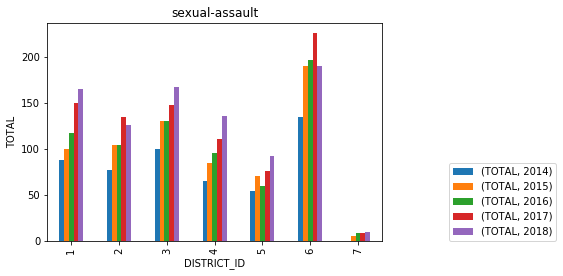

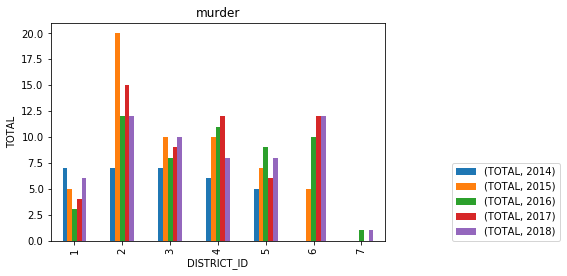

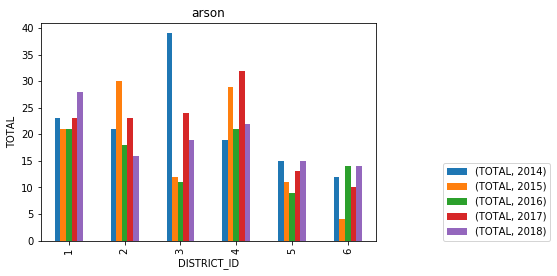

In [24]:
temp=denver_crime[['REPORTED_DATE','DISTRICT_ID','OFFENSE_CATEGORY_ID']]
for offense in denver_crime.OFFENSE_CATEGORY_ID.unique():
    temp2=temp[temp['OFFENSE_CATEGORY_ID']==offense].drop('OFFENSE_CATEGORY_ID', axis=1)
    temp2=temp2=temp2.groupby([temp2.REPORTED_DATE.dt.year,temp2.DISTRICT_ID]).agg('count')
    temp2.columns= ['TOTAL']
    temp2=temp2.unstack(level=0)
    temp2=temp2.plot(kind='bar')
    plt.ylabel('TOTAL')
    plt.legend(loc=(1.2,0))
    plt.title(offense)
    


It seems that district 3 is the center for theivery. It has very high rates of larceny, auto-theft,theft-from-motor-vehicles, white-collar-crime, and burglary. District 6 is the the hotspot for drug-alcohol crimes and also sports slightly higher than expected rates of aggravated-assualt and sexual-assualt. District 2 has very high murder rates which is strange given it is a relatively small district.

<font size=3><b> Heat Maps</b></font>



In this final section, I will generate some heatmps to help visualize the physical locations of crimes in Denver. In addition, I will create a function that will let you generate your own heatmaps as you see fit! I will first create the function I use to generate the heatmaps, then create several heatmaps myself, and then convey how you could create your own heatmaps!

In [25]:
# This function lets you create your own heatmaps using the provided latitude and longitude coordinates
# the function parameters filter denver_crime by its columns. pass in a tuple of (column_name,column_value) and it 
# will create a heatmap with the entries that satisfy the condition. You can have as many filters as you'd like
def heatmap_creator(*args):
    #filter out all entries with no Lat/Lon data
    check_for_coordinates=denver_crime['GEO_LAT'].isna()|denver_crime['GEO_LON'].isna()
    temp=denver_crime[~check_for_coordinates]
    #filter based on the provided parameters
    for item in args:
        a,b=item
        temp=temp[temp[a]==b]
        print(str(a)+': '+str(b))
    #Generate heatmap
    hm_prep=temp[['GEO_LAT','GEO_LON']].as_matrix()
    m = folium.Map(location=[39.73,-104.90], tiles='Stamen Toner',zoom_start=11, control_scale=True)
    m.add_children(plugins.HeatMap(hm_prep,radius=15))
    return display(m)


Above, I created the heatmap generating function. The heatmap has interactive zoom and uses javascript, so javascript must be enabled to see the heatmap. To read the heatmap, consider red areas to indicate many crimes, blue areas to meaan few crimes, and blank white areas to mean no crimes.

In [26]:
heatmap_creator(('OFFENSE_CATEGORY_ID','drug-alcohol'))

OFFENSE_CATEGORY_ID: drug-alcohol


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  app.launch_new_instance()


In [27]:
heatmap_creator(('MONTH_REPORTED',7),('YEAR_REPORTED',2015),('OFFENSE_CATEGORY_ID','drug-alcohol'))

MONTH_REPORTED: 7
YEAR_REPORTED: 2015
OFFENSE_CATEGORY_ID: drug-alcohol


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  app.launch_new_instance()


Those are a few sample heatmaps. In order to create your own, open this notebook in Jupyter Notebook, use the function heatmap_creator, and pass it a column-value pair as a tuple. heatmap_creator will filter Denver's total crime data by the criteria you submit, so if you run the code heatmap_creator(('OFFENSE_CATEGORY_ID','burglary')), it will construct a heatmap of all burglary type crimes recorded in Denver. You can even add multiple filters e.g. if you were to run heatmap_creator(('OFFENSE_CATEGORY_ID','burglary'),('YEAR_REPORTED',2015)), it would construct a heatmap of all burglaries that occured in 2015. I hope this tool proves useful, and I hope individual police departments can use it to identify crime hotspots within their precincts. 

<font size=5><b>End of EDA</font></b>

Thank you for reading through this exploratory data analysis. If there is any additional visualizations you would like, please let me know and I'll add them. I hope you saw something new, and have a great day!

<font size=3><b>Appendix</b></font>

In this section, I'm including a handful of graphs that I couldn't fit into the report, but still found interesting and may turn out useful

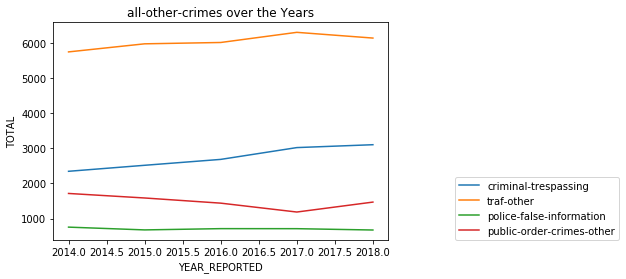

In [28]:
#all-other-crimes over the years
temp=denver_crime[denver_crime['OFFENSE_CATEGORY_ID']=='all-other-crimes']
temp=temp[['YEAR_REPORTED','OFFENSE_TYPE_ID']].groupby([temp.OFFENSE_TYPE_ID, temp.YEAR_REPORTED]).agg('count')
temp=temp.drop(labels='YEAR_REPORTED',axis=1)
temp.columns=['COUNT']
temp=temp.unstack(level=0)
temp['COUNT'][['criminal-trespassing','traf-other','police-false-information','public-order-crimes-other']].plot(kind='line')
plt.legend(loc=(1.2,0))
plt.ylabel('TOTAL')
plt.title('all-other-crimes over the Years')
plt.show()



The above graph breaks down the all-other-crimes category and shows how those crimes trended over the years. of note is that criminal trespassing is trending upwards, which may be expected given Denver's constantly increasing population.

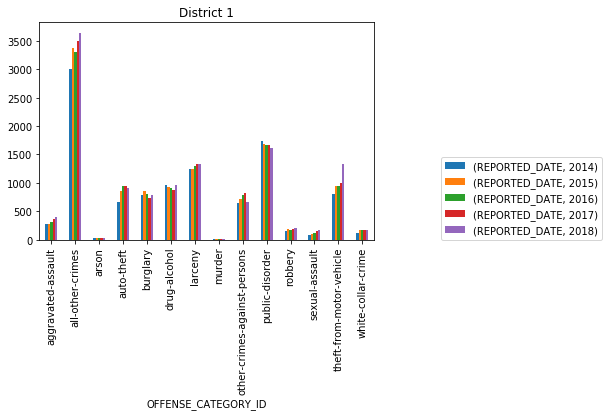

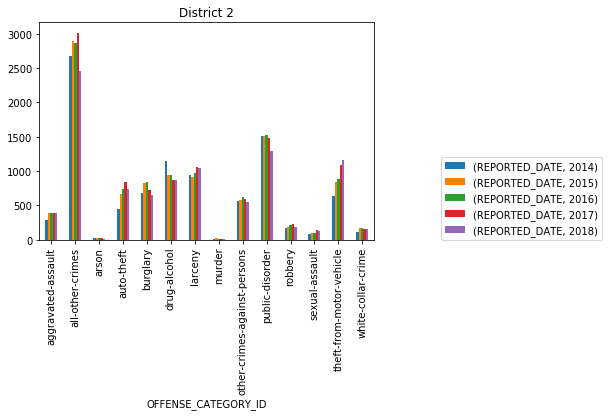

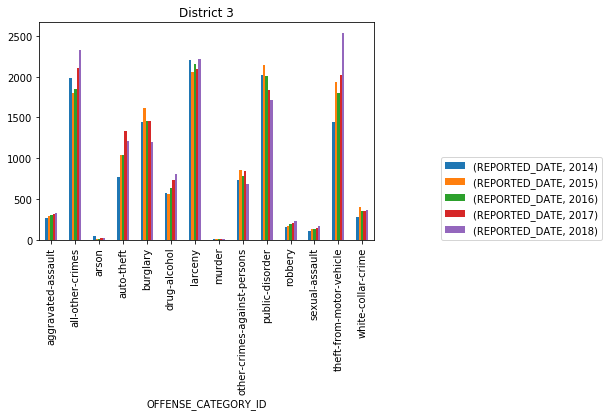

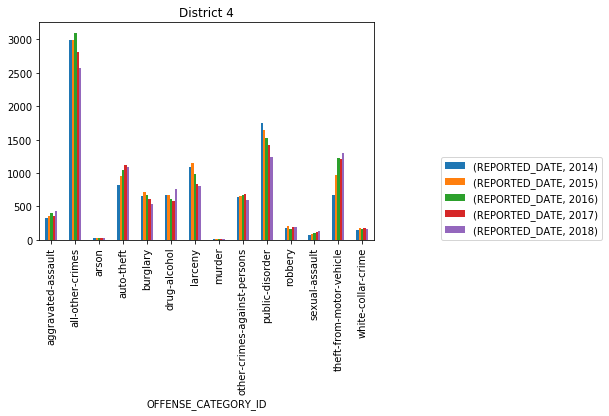

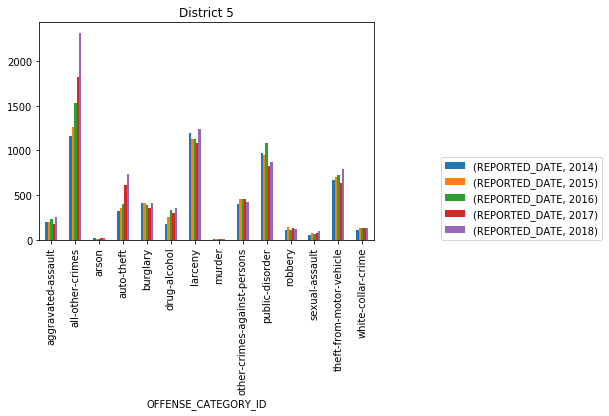

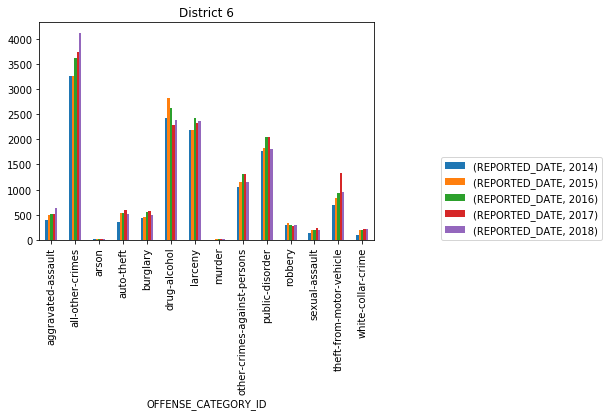

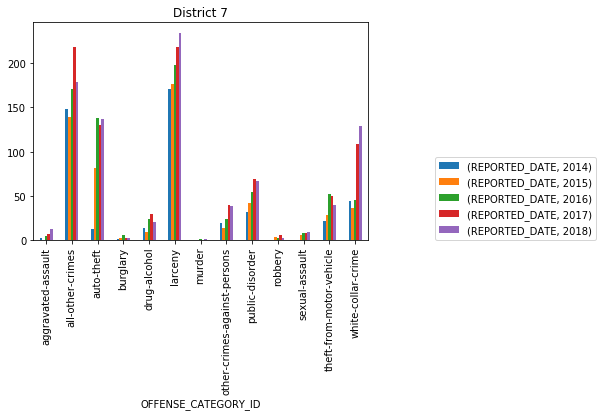

In [29]:
#crime breakdown within each district
temp=denver_crime[['REPORTED_DATE','DISTRICT_ID','OFFENSE_CATEGORY_ID']]
for district in range(1,8):
    temp2=temp[temp['DISTRICT_ID']==district].drop('DISTRICT_ID',axis=1)
    temp2=temp2.groupby([temp2.REPORTED_DATE.dt.year,temp2.OFFENSE_CATEGORY_ID]).agg('count')
    temp2=temp2.unstack(level=0).plot(kind='bar').legend(loc=(1.2,0))
    plt.title('District '+str(district))
    plt.show()

This distribution shows how crimes break down by type within each district. the data is organized differently from the district graphs earlier in the report, but they contain the same information. This orginization may be more useful to the individual police departments though; they may want a graph showcasing the crime trends in their district only.

In [30]:
denver_traffic=denver_data[denver_data['IS_TRAFFIC']==1]
check_for_coordinates=denver_traffic['GEO_LAT'].isna()|denver_traffic['GEO_LON'].isna()
temp=denver_traffic[~check_for_coordinates]
hm_prep=temp[['GEO_LAT','GEO_LON']].as_matrix()
m = folium.Map(location=[39.73,-104.90], tiles='Stamen Toner',zoom_start=11, control_scale=True)
m.add_children(plugins.HeatMap(hm_prep,radius=15))
display(m)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  


the dataset also included traffic data. Traffic incidents fell outside the scope of my analysis, which focused on crime, but I  created a heatmap of the data since it wasn't too much trouble. By zooming into the heatmap, you'll notice that most collisions occur at intersections, as you'd expect. Zooming in gives you a better visualization of the individual streets, and you'll notice some streets have more redspots than others; that indicates those streets have more collisions than others. Given the information I know, this heatmap doesn't tell me a whole lot as certain roads may have more accidents because they just have more traffic. If someone more familiar with the actual streets of Denver knows a particular intersection is ill-designed, this visualization could provide that person with supporting evidence. Combined with other traffic datasets, more meaningful conclusions can be drawn.

In [31]:
denver_crime[['DISTRICT_ID','NEIGHBORHOOD_ID']].groupby(['DISTRICT_ID','NEIGHBORHOOD_ID']).agg('count')

Empty DataFrame
Columns: []
Index: [(1, auraria), (1, baker), (1, barnum), (1, barnum-west), (1, berkeley), (1, cbd), (1, chaffee-park), (1, elyria-swansea), (1, globeville), (1, highland), (1, jefferson-park), (1, lincoln-park), (1, regis), (1, sloan-lake), (1, sun-valley), (1, sunnyside), (1, villa-park), (1, west-colfax), (1, west-highland), (2, cheesman-park), (2, cherry-creek), (2, city-park), (2, clayton), (2, cole), (2, congress-park), (2, east-colfax), (2, elyria-swansea), (2, five-points), (2, hale), (2, montclair), (2, north-park-hill), (2, northeast-park-hill), (2, skyland), (2, south-park-hill), (2, stapleton), (2, whittier), (3, baker), (3, belcaro), (3, cheesman-park), (3, cherry-creek), (3, cory-merrill), (3, country-club), (3, goldsmith), (3, hampden), (3, hampden-south), (3, hilltop), (3, indian-creek), (3, kennedy), (3, lowry-field), (3, overland), (3, platt-park), (3, rosedale), (3, southmoor-park), (3, speer), (3, university), (3, university-hills), (3, university-park), (3, virginia-village), (3, washington-park), (3, washington-park-west), (3, washington-virginia-vale), (3, wellshire), (3, windsor), (4, athmar-park), (4, barnum), (4, barnum-west), (4, bear-valley), (4, college-view-south-platte), (4, fort-logan), (4, harvey-park), (4, harvey-park-south), (4, mar-lee), (4, marston), (4, ruby-hill), (4, valverde), (4, westwood), (5, dia), (5, gateway-green-valley-ranch), (5, montbello), (5, stapleton), (6, auraria), (6, capitol-hill), (6, cbd), (6, cheesman-park), (6, city-park-west), (6, civic-center), (6, five-points), (6, north-capitol-hill), (6, union-station), (7, dia)]

In the analysis, I grouped crimes based off of the district in which the occurred. However, most people recognize locations in the city by neighborhood/area, not police district. The above table shows which neighborhoods are in which police district. This should help lamens identify the types of crimes in their neighborhoods, and more interpret the analyses presented in this kernel